# Convolutional neural networks
This notebook uses the `hybridmodels-modelbuild` virtual environment.

In [1]:
from os.path import join
import glob
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def get_rows_and_cols(df, gridsize=500):
    """
    Calculate no. rows and cols in grid.
    
    Parameters:
    -----------
    gridsize : float
        length of one side of a square gridcell in grid.
    """
    from shapely.geometry import box
    df_pm = df.to_crs("EPSG:3857")
    bbounds = df_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / gridsize, 0))
    ncols = int(np.round(width  / gridsize, 0))
    return nrows, ncols

def reshape_df(df, nrows, ncols, features):
    df = df.drop("geometry", axis=1)
    feature_mat = np.empty(shape=(nrows, ncols, len(features)), dtype="float")
    for i, feature in enumerate(features):
        feature_arr = df[feature].values.reshape(nrows, ncols, order="F")
        feature_mat[:, :, i] = feature_arr
    return feature_mat

## Load and parse data

In [2]:
# load the data
wd = join("..", "data", "indata_new")
features = ['gebco', 'fabdem', 'jrc_permwa', 'precip', 'ndvi', 'mangrove', 'soilcarbon', 'wind_avg']
columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]
staggering = False

# separate files based on staggering level
files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
orig_mask = [True if filename.split('.')[-2][-2:] == '_0' else False for filename in files]
plus_mask = [True if filename.split('.')[-2][-4:] == '_250' else False for filename in files]
minus_mask = [True if filename.split('.')[-2][-4:] == '-250' else False for filename in files]
orig = list(compress(files, orig_mask))
plus = list(compress(files, plus_mask))
minus = list(compress(files, minus_mask))

# format event columns
def format_gdf(filelist):
    l = [gpd.read_file(filename) for filename in filelist]
    gdf = pd.concat(l, axis=0)
    gdf = gdf[columns]
    print("Number of storms:", gdf["storm"].nunique())
    print("Number of regions:", gdf["region"].nunique())
    gdf["event"] = gdf["storm"] + "_" + gdf["region"] + "_" + gdf["subregion"].astype(str)
    gdf = gdf.drop(["storm", "region", "subregion"], axis=1).reset_index(drop=True)
    return gdf

gdf = format_gdf(orig)
if staggering:
    gdf_plus = format_gdf(plus)
    gdf_minus = format_gdf(minus)

columns.remove("storm")
columns.remove("region")
columns.remove("subregion")

print("Number of unique ROIs:", gdf['event'].nunique())

Number of storms: 8
Number of regions: 16
Number of unique events: 35


Roanu number of grid cells:  53248


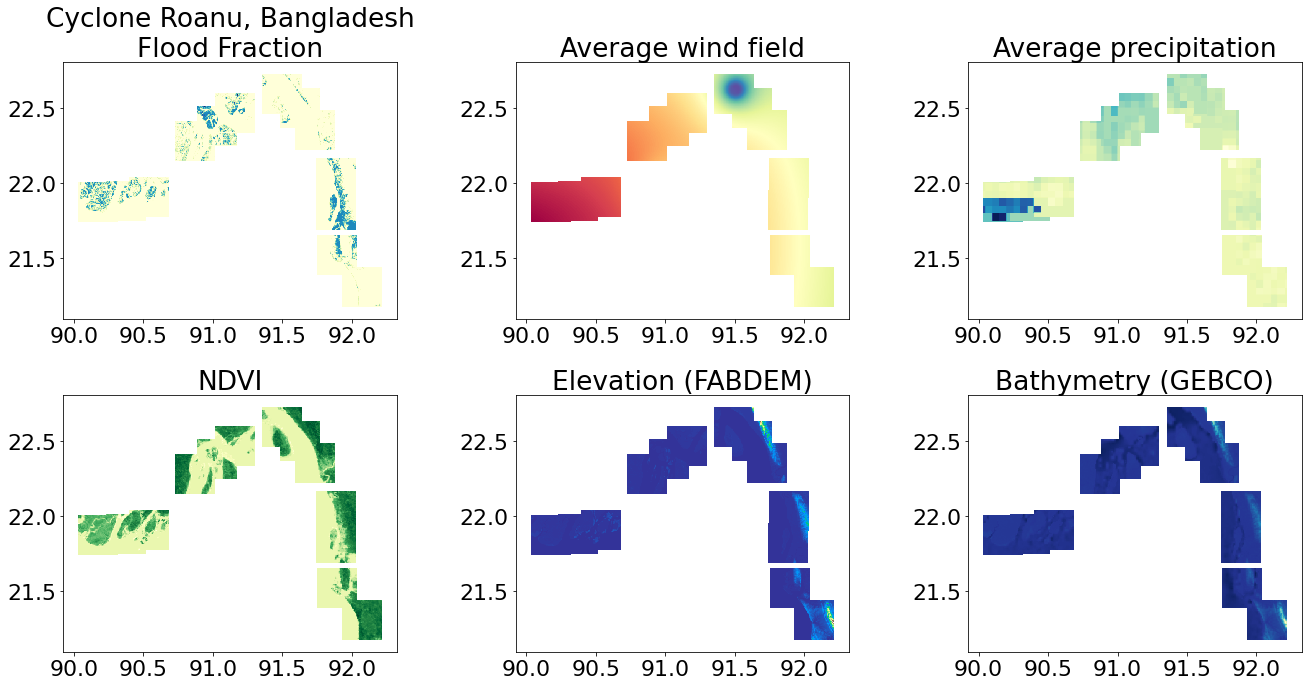

In [12]:
# messy code: clean up later
plt.rcParams.update({'font.size': 22})
gdf_roanu = gdf[gdf["event"].str.split("_", expand=True)[0] == "roanu"]
fig, ax = plt.subplots(2, 3, figsize=(20, 10), layout="tight")

gdf_roanu.plot("floodfrac", ax=ax[0, 0], cmap="YlGnBu")
gdf_roanu.plot("wind_avg", ax=ax[0, 1], cmap="Spectral_r")
gdf_roanu.plot("precip", ax=ax[0, 2], cmap="YlGnBu")
gdf_roanu.plot("ndvi", ax=ax[1, 0], cmap="YlGn")
gdf_roanu.plot("fabdem", ax=ax[1, 1], cmap="terrain")
gdf_roanu.plot("gebco", ax=ax[1, 2], cmap="YlGnBu_r")

ax[0, 0].set_title("Cyclone Roanu, Bangladesh\nFlood Fraction");
ax[0, 1].set_title("Average wind field");
ax[0, 2].set_title("Average precipitation");
ax[1, 0].set_title("NDVI");
ax[1, 1].set_title("Elevation (FABDEM)");
ax[1, 2].set_title("Bathymetry (GEBCO)");

plt.savefig(join(wd, "roanu_sample.png"), bbox_inches="tight")

print("Roanu number of grid cells: ", len(gdf_roanu))

In [236]:
gdf_roanu.columns

Index(['gebco', 'fabdem', 'jrc_permwa', 'precip', 'ndvi', 'mangrove',
       'soilcarbon', 'wind_avg', 'geometry', 'floodfrac', 'event'],
      dtype='object')

## Single-site: Tropical Cyclone Roanu, Bangladesh
Now limit to only studying Tropical Cyclone Roanu in Bangladesh.

skew: 2.400041580355783
kurtosis: 4.679991099441086


count    53248.000000
mean         0.110786
std          0.251277
min          0.000000
25%          0.000000
50%          0.000000
75%          0.018618
max          1.551487
Name: floodfrac, dtype: float64

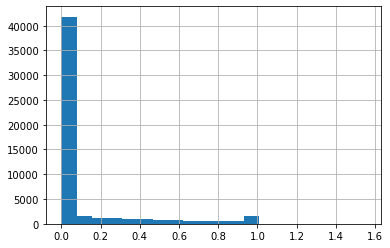

In [249]:
print(f"skew: {gdf['floodfrac'].skew()}")
print(f"kurtosis: {gdf['floodfrac'].kurtosis()}")
gdf['floodfrac'].hist(bins=20)
gdf['floodfrac'].describe()

### Format training set
[Help for the binary, weighted case](https://github.com/keras-team/keras/issues/3653#issuecomment-557844450)

    # preview training set with missing values (to mask later)
    events = [*gdf['event'].unique()]

    event = 'batsirai_tsiribihina_0'
    temp = gdf[gdf.event==str(event)]
    nrows, ncols = get_rows_and_cols(temp, gridsize=500)
    X = reshape_df(temp, nrows, ncols, features)
    y = reshape_df(temp, nrows, ncols, ["floodfrac"])

    # clip to size
    X = X[:64, :64, :]
    y = y[:64, :64, 0]

    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(Xmat[:, :, 2], cmap="YlGnBu")
    ax[0].set_title("JRC Permwater")
    ax[1].imshow(ymat, cmap="YlGnBu")
    ax[1].set_title("Flood fraction")

In [265]:
Xmats = []
ymats = []

def get_matrices(gdf, gridsize, features):
    """Helper function for reshaping."""
    nrows, ncols = get_rows_and_cols(gdf, gridsize=gridsize)
    X = reshape_df(gdf, nrows, ncols, features)
    y = reshape_df(gdf, nrows, ncols, ["floodfrac"])
    
    # clip to 64x64 images
    X = X[:64, :64, :]
    y = y[:64, :64, 0]
    
    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y
    return Xmat, ymat
    
# now calculate X and y matrices
for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat = get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)

if staggering:
    for event in [*gdf_plus['event'].unique()]:
        temp = gdf_plus[gdf_plus.event==str(event)]
        if len(temp) > 0:
            Xmat, ymat = get_matrices(temp, 500, features)
            Xmats.append(Xmat)
            ymats.append(ymat)

    for event in [*gdf_minus['event'].unique()]:
        temp = gdf_minus[gdf_minus.event==str(event)]
        if len(temp) > 0:
            Xmat, ymat = get_matrices(temp, 500, features)
            Xmats.append(Xmat)
            ymats.append(ymat)
            
ymats_flat = [mat.flatten() for mat in ymats]
ymats_onehot = [tf.one_hot(mat, 2) for mat in ymats_flat]

In [266]:
# create TensorFlow datasets with batch size 1 (since small dataset)
n = len(Xmats)
ntrain = int(0.6 * n)
ntest = int(0.2 * n)

data = tf.data.Dataset.from_tensor_slices((Xmats, ymats_flat, ymats_flat)).batch(1)  # weights third entry in tuple
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

X_train = [element[0].numpy()[0, :, :, :] for element in train]
y_train = [element[1].numpy()[0, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
y_valid = [element[1].numpy()[0, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]
y_test = [element[1].numpy()[0, :] for element in test]

print("Dataset size:", n)
print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Dataset size: 35
Training size: 21
Validation size: 7
Test size: 7


In [267]:
print("X train shape:", X_train[0].shape)
print("y train shape:", y_train[0].shape)

X train shape: (64, 64, 8)
y train shape: (4096,)


### View training set

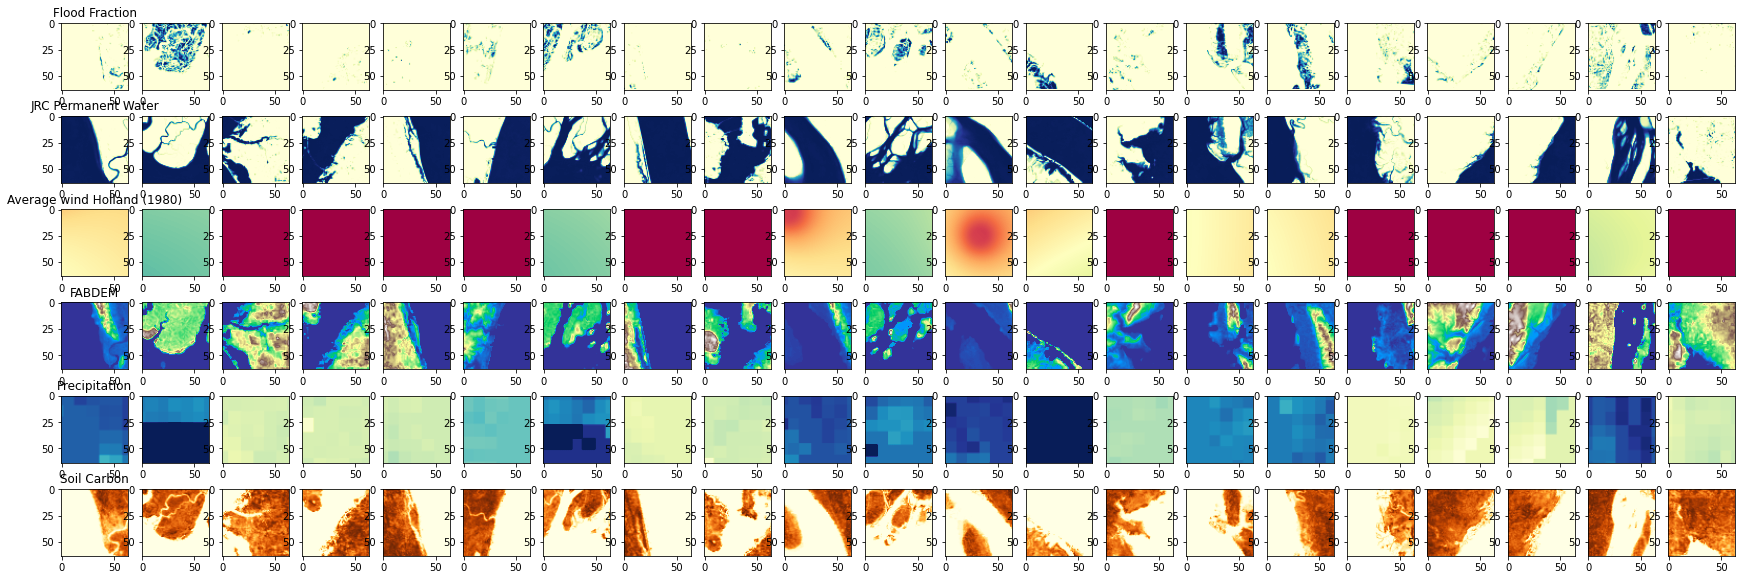

In [268]:
fig, ax = plt.subplots(6, len(y_train), figsize=(30, 10))

for i, im in enumerate(y_train):
    pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
    ax[0, 0].set_title(f"Flood Fraction")
    
for i, im in enumerate(X_train):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, 0].set_title("JRC Permanent Water")

for i, im in enumerate(X_train):
    pos = ax[3, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
    ax[3, 0].set_title("FABDEM")

for i, im in enumerate(X_train):
    pos = ax[2, i].imshow(im[:, :, 7], cmap="Spectral", vmin=8.5, vmax=10.5)
    ax[2, 0].set_title("Average wind Holland (1980)")
    
for i, im in enumerate(X_train):
    pos = ax[4, i].imshow(im[:, :, 3], cmap="YlGnBu", vmin=0, vmax=40)
    ax[4, 0].set_title("Precipitation")
    
for i, im in enumerate(X_train):
    pos = ax[5, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[5, 0].set_title("Soil Carbon")
    
plt.savefig(join(wd, "trainingset.png"), bbox_inches="tight")

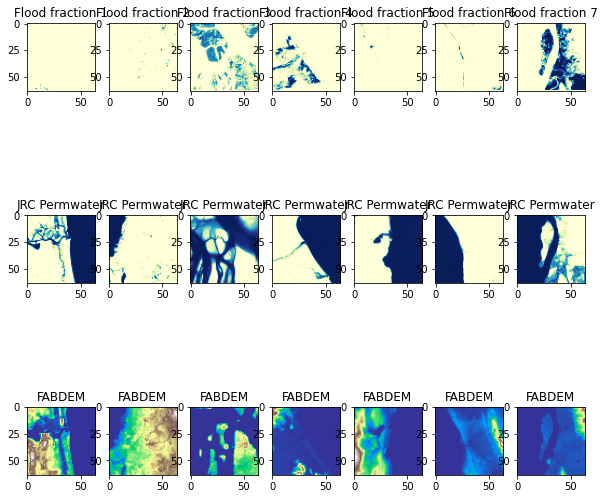

In [269]:
fig, ax = plt.subplots(3, len(y_test), figsize=(10, 10))
for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
    ax[0, i].set_title(f"Flood fraction {i+1}")
    
for i, im in enumerate(X_test):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")
    
for i, im in enumerate(X_test):
    pos = ax[2, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
    ax[2, i].set_title("FABDEM")
    
plt.savefig(join(wd, "testset.png"), bbox_inches="tight")

### Model hyperparameters
Since the target variable `floodfrac` is very positively-skewed, with many zeros, any Gaussian-assuming loss function such as RMSE can lead to poor results due to zero-inflation. The Tweedie loss function has been developed to deal with this sort of data and is [often used in predicting insurance claims](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). A custom TensorFlow function is provided [here](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). The loss function corresponds to the negative log-likelihood of the Tweedie compound Poisson-Gamma distribution, which has the following form,

$$ \mathcal{L}(p) = -\sum_{i} x_i \frac{\hat x_i^{1-p}}{1-p} + \frac{\hat x_i^{2-p}}{2-p}$$

where $y$ is the trye value, and $\hat y$ is the predicted value. For the optimiser either, stochastic gradient descent with a small (1e-6) learning rate, or else Adam with an adaptive learning rate will be used. Epochs range between 20 and 200 and will need to be explored.
#### Possible future extensions
1. [ ] partialconv or mirrored padding
2. [ ] dilation to layers

In [270]:
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Reshape
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, Recall
from tensorflow.keras import Model

def Tweedie(p):
    """Loss for continuous target variable."""
    def tweedie_loglikelihood(y, y_hat):
        loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
               tf.pow(y_hat, 2 - p) / (2 - p)
        return tf.reduce_mean(loss)
    return tweedie_loglikelihood

def plot_history(history, metric='root_mean_squared_error'):
    if not type(metric)==str:
        metric = metric.__name__.lower()
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.plot(history.epoch, np.array(history.history[metric]), 
           label='train')
    plt.plot(history.epoch, np.array(history.history[f'val_{metric}']),
           label = 'valid')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])
    
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

### SCNN, Matéo-Garcia (2021)

In [271]:
def build_scnn(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=k_init)(normalized)
    x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    outputs = Reshape((64*64, 1))(outputs)
    scnn = Model(inputs, outputs, name="SCNN")
    return scnn


scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)), k_init="lecun_normal")
scnn.summary()

Model: "SCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 64, 64, 8)]       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 64, 64, 8)         32        
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 64, 64, 64)        4672      
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 64, 64, 1)         129       
_________________________________________________________________
reshape_8 (Reshape)          (None, 4096, 1)           0      

Epoch 1/100
21/21 [==============================] - 1s 46ms/step - loss: 0.0882 - root_mean_squared_error: 0.5399 - val_loss: 0.0608 - val_root_mean_squared_error: 0.8156
Epoch 2/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0877 - root_mean_squared_error: 0.5316 - val_loss: 0.0582 - val_root_mean_squared_error: 0.7259
Epoch 3/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0872 - root_mean_squared_error: 0.5232 - val_loss: 0.0562 - val_root_mean_squared_error: 0.6698
Epoch 4/100
21/21 [==============================] - 1s 40ms/step - loss: 0.0868 - root_mean_squared_error: 0.5147 - val_loss: 0.0546 - val_root_mean_squared_error: 0.6334
Epoch 5/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0863 - root_mean_squared_error: 0.5061 - val_loss: 0.0532 - val_root_mean_squared_error: 0.6031
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 0.0858 - root_mean_squared_error: 0.4975 - val_loss: 0.0518 - val_

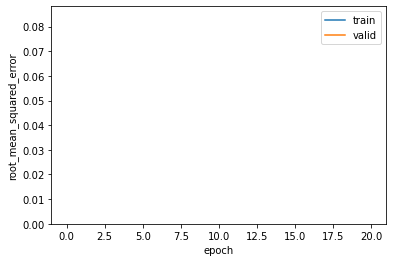

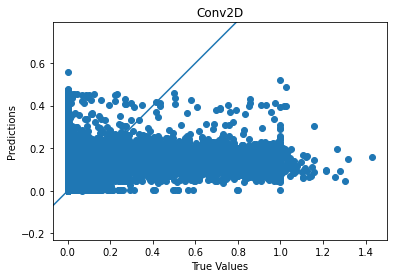

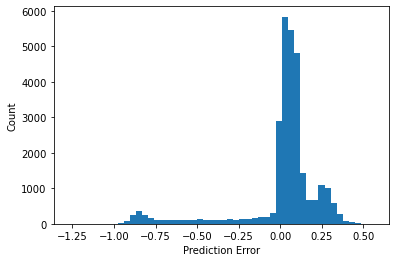

In [272]:
scnn.compile(optimizer=SGD(learning_rate=1e-3),
             loss=Tweedie(1.5),
             metrics="RootMeanSquaredError",
             sample_weight_mode='temporal')  # , weighted_metrics=)
history = scnn.fit(train, epochs=100, validation_data=valid, callbacks=EarlyStopping(patience=3))

plot_history(history)

[loss, rmse] = scnn.evaluate(test, verbose=0)
print("\n\nTesting set root mean squared error: {:4.2f}".format(rmse))

y_pred = scnn.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

!say done

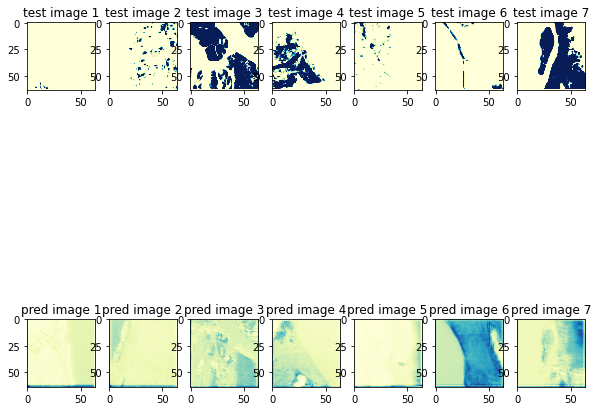

In [273]:
fig, ax = plt.subplots(2, len(y_test), figsize=(10, 10))

if len(y_test) > 1:
    for i, im in enumerate(y_test):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=0.1)
        ax[0, i].set_title(f"test image {i+1}")

    for i, _ in enumerate(y_test):
        ax[1, i].imshow(y_pred[i].reshape(64, 64), cmap="YlGnBu")
        ax[1, i].set_title(f"pred image {i+1}")
else:
    for i, im in enumerate(y_test):
        pos = ax[0].imshow(im.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=0.1)
        ax[0].set_title(f"test image {i+1}")

    for i, _ in enumerate(y_test):
        ax[1].imshow(y_pred[i].reshape(64, 64), cmap="YlGnBu")
        ax[1].set_title(f"pred image {i+1}")

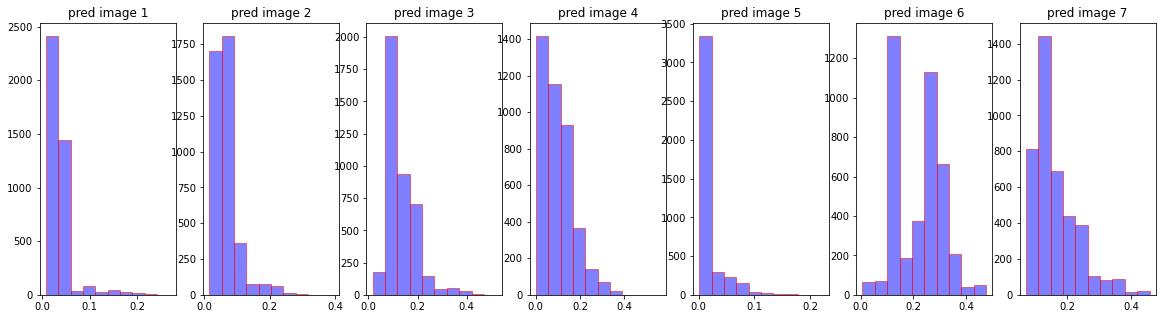

In [274]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i], alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")

### U-Net
U-Net
[Keras implementation from here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)


In [275]:
# define the U-Net architecture (from Tutorial)
def double_conv_block(x, depth, k_init):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    return x

def downsample_block(x, depth, k_init):
    f = double_conv_block(x, depth, k_init)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth, k_init):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth, k_init)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64, k_init)
    f2, p2 = downsample_block(p1, 128, k_init)
    f3, p3 = downsample_block(p2, 256, k_init)
    f4, p4 = downsample_block(p3, 512, k_init)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024, k_init)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512, k_init)
    u7 = upsample_block(u6, f3, 256, k_init)
    u8 = upsample_block(u7, f2, 128, k_init)
    u9 = upsample_block(u8, f1, 64, k_init)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    outputs = Reshape((64*64, 1))(outputs)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [276]:
unet = build_unet(shape=(64, 64, len(features)), k_init="lecun_normal")
unet.compile(optimizer=SGD(learning_rate=1e-3),
             loss=Tweedie(1.5),
             metrics="RootMeanSquaredError",
             sample_weight_mode='temporal'
            )
history = unet.fit(train, epochs=40, validation_data=valid, callbacks=EarlyStopping(patience=3))

!say done

Epoch 1/40
21/21 [==============================] - 6s 240ms/step - loss: 0.0814 - root_mean_squared_error: 0.4166 - val_loss: 0.0347 - val_root_mean_squared_error: 0.2638
Epoch 2/40
21/21 [==============================] - 5s 227ms/step - loss: 0.0813 - root_mean_squared_error: 0.4151 - val_loss: 0.0364 - val_root_mean_squared_error: 0.3029
Epoch 3/40
21/21 [==============================] - 5s 229ms/step - loss: 0.0812 - root_mean_squared_error: 0.4135 - val_loss: 0.0377 - val_root_mean_squared_error: 0.3285
Epoch 4/40
21/21 [==============================] - 5s 230ms/step - loss: 0.0811 - root_mean_squared_error: 0.4117 - val_loss: 0.0387 - val_root_mean_squared_error: 0.3461


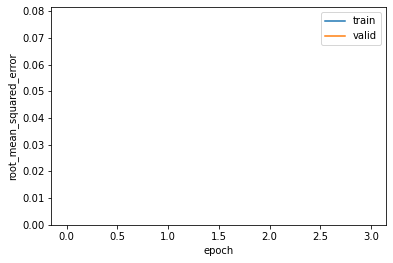

In [277]:
plot_history(history)

Testing set root mean squared error: 0.35


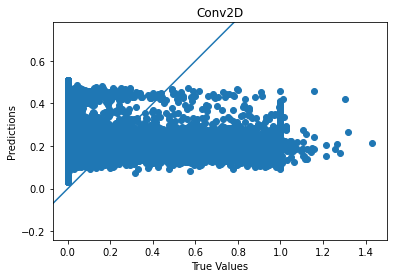

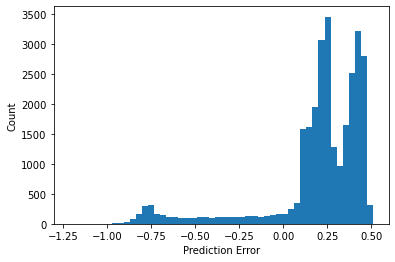

In [278]:
[loss, rmse] = unet.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

y_pred = unet.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

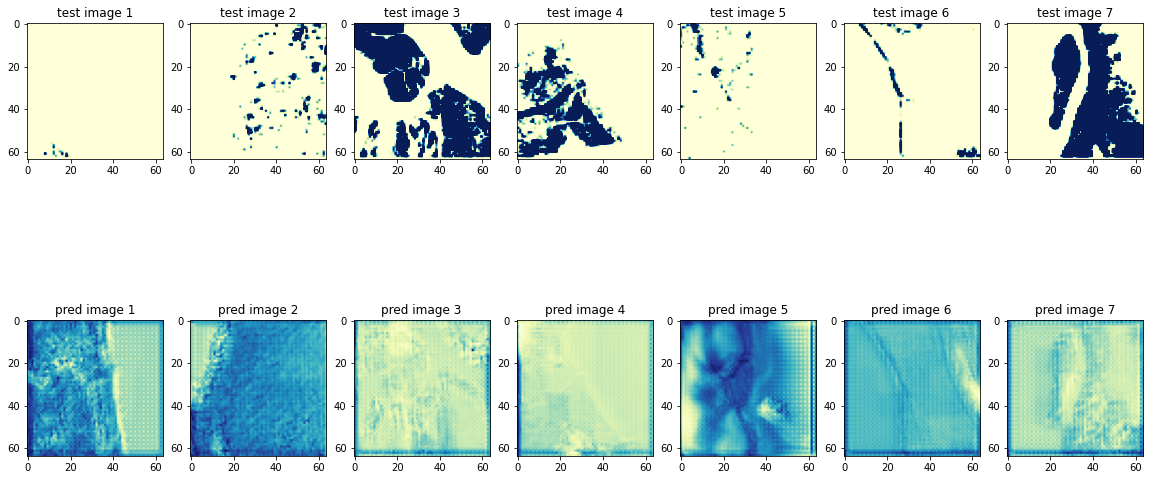

In [279]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

if len(y_test) > 1:
    for i, im in enumerate(y_test):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu", vmin=0, vmax=0.1)
        ax[0, i].set_title(f"test image {i+1}")

    for i, _ in enumerate(y_test):
        ax[1, i].imshow(y_pred[i].reshape(64, 64), cmap="YlGnBu")
        ax[1, i].set_title(f"pred image {i+1}")
else:
    for i, im in enumerate(y_test):
        pos = ax[0].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
        ax[0].set_title(f"test image {i+1}")

    for i, _ in enumerate(y_test):
        ax[1].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
        ax[1].set_title(f"pred image {i+1}")

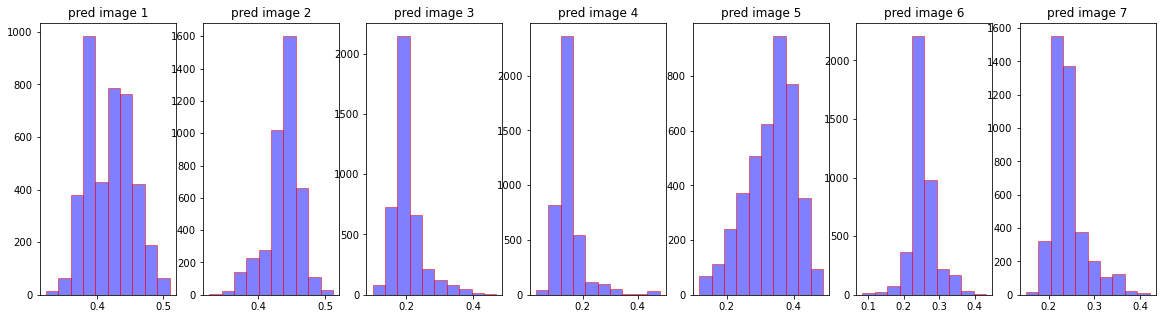

In [280]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i], alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")